# Adsorption of Monomers
* Adsorption Monomers: Adsorption of ideal gas

In [1]:
%pylab notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit


Populating the interactive namespace from numpy and matplotlib


In [2]:
'''
modifed BFM Simulator for noninteracting particles
* no lattice occupation check -> no excluded volume
* no neighbor interactions -> model of ideal gas
* no connections -> no bond partner list, bond vector checks
''' 

class monomer:
    ''' monomer class with unique index, containing the coordinates and attributes of a single monomer '''
    def __init__(self, idx_, coords_, attributes_):
        ''' setting properties of monomer:
        idx: unique index (int),
        coords: d-dimensional coordinates (np.array),
        attributes: dict of properties (python dict),
        '''
        self.idx = idx_
        self.coords = coords_
        self.attributes = attributes_
#

class LatticeGasSimulator:
    ''' class providing utilities for 3D lattice gas simulations:
    monomer container, move and apply function '''
    def __init__(self, box_, periodicity_, delta_):
        ''' setting up simulation box:
        box = [boxX, boxY, boxZ] (python list of int),
        periodicity = [pX, pY, pZ] (python list of bools), True = is periodic, False = wall
        delta (float, interaction energy)
        ... and setup:
        empty molecules as empty list,
        calcualte probability factor from delta (float),
        list of moves (python list)'''
        self.boxX, self.boxY, self.boxZ = box_
        self.pX, self.pY, self.pZ = periodicity_
        self.delta = delta_
        self.probabilityMultiplicator = np.exp(-self.delta)
        self.molecules = []
        self.moves = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
        
    def addMonomer(self, coords, attributes):
        ''' add new monomer at the end of molecules '''
        newIdx = len(self.molecules)
        self.molecules.append(monomer(newIdx ,coords, attributes))
        
    def plotConfig(self):
        ''' plot all monomers using scatter and bonds using plot with the box as axis boundaries '''
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colorList = ["green","red"]
        
        # here, fold back is simple because there are no bonds
        myX = np.array([((x.coords[0]%self.boxX)+self.boxX)%self.boxX for x in self.molecules])
        myY = np.array([((x.coords[1]%self.boxY)+self.boxY)%self.boxY for x in self.molecules])
        myZ = np.array([((x.coords[2]%self.boxZ)+self.boxZ)%self.boxZ for x in self.molecules])
        
        myFixed = [(x.coords[2]==0 or x.coords[2]== (self.boxX-2) ) for x in self.molecules]
        myColors = [colorList[int(c)] for c in myFixed ]
        ax.scatter(myX,myY,myZ, c=myColors)
        
        ax.set_xlim3d(0, self.boxX)
        ax.set_ylim3d(0, self.boxY)
        ax.set_zlim3d(0, self.boxZ)
        
        fig.show()
    
    def checkMove(self, idx, direction):
        ''' apply the move checks for monomer with index idx:
        takes monomer id and key of move direction [0,self.Nmoves)
        check boundaries and adsorption energy'''

        # get new position
        oldPos = self.molecules[idx].coords
        oldX, oldY, oldZ = oldPos
        newPos = self.molecules[idx].coords + self.moves[direction]
        x, y, z = newPos
        totalProb = 1.0
        
        # check boundaries and adsorption energy: 
        if not self.pX:
            if x == -1 or x == (self.boxX-1):
                return False
            
            # monomer approaches the wall: 
            if (x == 0 and oldX == 1) or (x == (self.boxX-2) and oldX == (self.boxX-3)):
                # increase move probability if monomer wants to attach the wall
                totalProb /= self.probabilityMultiplicator
                #print("wall attach in x dir: ", x, oldPos, self.boxX, 1/self.probabilityMultiplicator, totalProb)
            # monomer detaches from the wall 
            elif (x == 1 and oldX == 0) or (x == (self.boxX-3) and oldX == (self.boxX-2)):
                # reduce move probability if monomer wants to leave the wall
                totalProb *= self.probabilityMultiplicator
                #print("wall detach in x dir: ", x, oldPos, self.boxX, self.probabilityMultiplicator, totalProb)
                
        if not self.pY:
            if y == -1 or y == (self.boxY-1):
                return False
            
            # monomer approaches the wall: 
            if (y == 0 and oldY == 1) or (y == (self.boxY-2) and oldY == (self.boxY-3)):
                # increase move probability if monomer wants to attach the wall
                totalProb /= self.probabilityMultiplicator
                #print("wall attach in y dir: ", y, oldPos, self.boxY, 1/self.probabilityMultiplicator, totalProb)
            # monomer detaches from the wall 
            elif (y == 1 and oldY == 0) or (y == (self.boxY-3) and oldY == (self.boxY-2)):
                # reduce move probability if monomer wants to leave the wall
                totalProb *= self.probabilityMultiplicator
                #print("wall detach in y dir: ", y, oldPos, self.boxY, self.probabilityMultiplicator, totalProb)
                
        if not self.pZ:
            if z == -1 or z == (self.boxZ-1):
                return False
            
            # monomer approaches the wall: 
            if (z == 0 and oldZ == 1) or (z == (self.boxZ-2) and oldZ == (self.boxZ-3)):
                # increase move probability if monomer wants to attach the wall
                totalProb /= self.probabilityMultiplicator
                #print("wall attach in z dir: ", z, oldPos, self.boxZ, 1/self.probabilityMultiplicator, totalProb)
            # monomer detaches from the wall 
            elif (z == 1 and oldZ == 0) or (z == (self.boxZ-3) and oldZ == (self.boxZ-2)):
                # reduce move probability if monomer wants to leave the wall
                totalProb *= self.probabilityMultiplicator
                #print("wall detach in z dir: ", z, oldPos, self.boxZ, self.probabilityMultiplicator, totalProb)
                
        # perform metropolis algorithm
        if ( totalProb < 1.0 ):
            if ( random.random() > totalProb ):
                return False
        
        # if still here, all checks have been passed
        return True
        
    def applyMove(self,idx,direction):
        ''' apply a move: set new coordinate in molecules '''
        newPos = (self.molecules[idx].coords + self.moves[direction])
        self.molecules[idx].coords = (newPos)

    def performMCS(self,time):
        ''' apply the lattice gas algorithm on a given system for 'time' Monte Carlo sweeps '''
        counter = 0
        mol_size = len(self.molecules)
        num_steps = len(self.moves)
        for t in range(time):
            for n in range(mol_size):
                randomIdx = random.randint(mol_size)
                randomDir = random.randint(num_steps)
                if self.checkMove(randomIdx,randomDir):
                    self.applyMove(randomIdx,randomDir)
                    counter += 1
        if counter == 0:
            print( "nothing moved... ")
        #print("applied moves / attempted moves:\n{} / {} = {}".format(counter, time*mol_size, counter/(time*mol_size))) 

def calculateWallContacts(simulator):
    ''' calcualte the number of monomers at nonperiodic walls and normalize it by the total number of monomers'''
    nContacts = 0
    for mono in simulator.molecules:
        if not simulator.pX:
            if ( mono.coords[0] == 0 or mono.coords[0] == (simulator.boxX-2) ):
                nContacts+=1
        if not simulator.pY:
            if ( mono.coords[1] == 0 or mono.coords[1] == (simulator.boxY-2) ):
                nContacts+=1
        if not simulator.pZ:
            if ( mono.coords[2] == 0 or mono.coords[2] == (simulator.boxZ-2) ):
                nContacts+=1
    return nContacts/len(simulator.molecules)

def adsorptIsothermTheo(d,V):
    ''' returns the theoretical prediction of the adsorption isotherm of ideal gas from Boltzmann statistics'''
    return np.exp(d)/(np.exp(d)+V)


0.09375


<IPython.core.display.Javascript object>


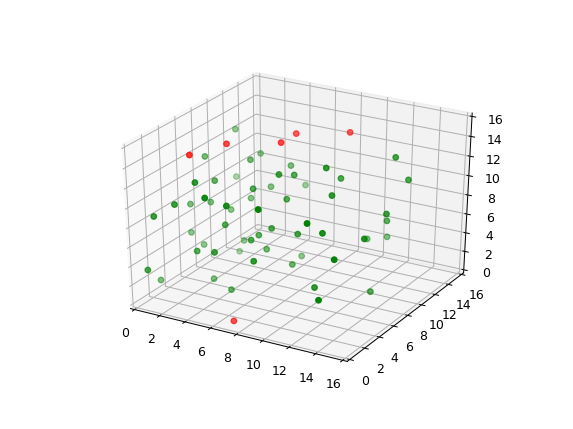

In [3]:
# some tests
box = 16
periodic = [True, True, False]
numMonos = 64
delta = 8

testGas = LatticeGasSimulator([box,box,box], periodic, delta)
for n in range(numMonos):
    newPos = random.randint(box-1,size=(3))
    testGas.addMonomer(newPos, {})

print(calculateWallContacts(testGas))
testGas.plotConfig()

In [4]:
# run the simulations
box = 32
periodic = [True, True, False]
numMonos = 256
delta = [0.0,0.05,0.1,0.2,0.4,0.6,0.8,1.0,1.2,1.5,2.0,3,4,5,6,7,8,9,10]
n_samples = 500
n_time = 100
'''   --------------------   '''
meanAdsorbedMonos = np.zeros((len(delta)))

for k, d in enumerate(delta):
    # setup
    gasSim = LatticeGasSimulator([box,box,box], periodic, d)
    newPos = random.randint(box-1,size=(numMonos,3))
    for n in range(numMonos):
        gasSim.addMonomer(newPos[n,:], {})
        
    # equilibrate
    gasSim.performMCS(1000)
    
    # sample
    nMean = 0.0
    for i in range(n_samples):
        gasSim.performMCS(n_time)
        nMean += calculateWallContacts(gasSim)
    
    print(d,nMean / n_samples)
    meanAdsorbedMonos[k] = (nMean / n_samples)
    
print(meanAdsorbedMonos)
data = np.vstack((delta,meanAdsorbedMonos)).transpose()
np.savetxt("adsorption_N256_b32.dat",data)

0.0 0.063796875
0.05 0.066890625
0.1 0.0714296875
0.2 0.0775
0.4 0.0929140625
0.6 0.1111171875
0.8 0.1313046875
1.0 0.15628125
1.2 0.1868046875
1.5 0.23721875
2.0 0.3362734375
3 0.583421875
4 0.79028125
5 0.9089765625
6 0.964125
7 0.985359375
8 0.9935
9 0.9965390625
10 0.998078125
[0.06379688 0.06689062 0.07142969 0.0775     0.09291406 0.11111719
 0.13130469 0.15628125 0.18680469 0.23721875 0.33627344 0.58342187
 0.79028125 0.90897656 0.964125   0.98535938 0.9935     0.99653906
 0.99807813]


<IPython.core.display.Javascript object>


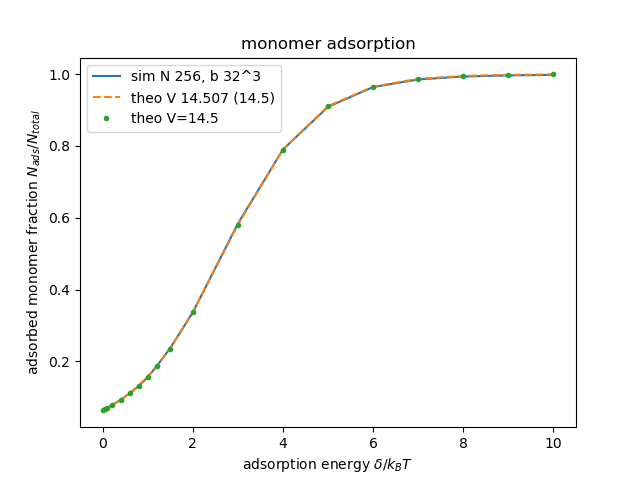

In [5]:
figure()
plot(delta,meanAdsorbedMonos, label="sim N {}, b {}^3".format(numMonos, box))
fit_params, covar = curve_fit( adsorptIsothermTheo, delta, meanAdsorbedMonos )
plot(delta,adsorptIsothermTheo(delta,fit_params[0]),"--", label="theo V {0:.3f} ({1:.1f})".format(fit_params[0],(box*box*(box-3))/(box*box*2)))
plot(delta,adsorptIsothermTheo(delta,14.5),".", label="theo V=14.5")
xlabel(r"adsorption energy $\delta / k_B T$")
ylabel(r"adsorbed monomer fraction $N_{ads} / N_{total}$")
legend(loc="best")
title("monomer adsorption")
show()